## Final Project Submission - Module 2 - EDA and Regression Model (2of2)

Please fill out:
* Student name: John Cho
* Student pace: full time online
* Scheduled project review date/time: 2/25/20
* Instructor name: Rafael Carrasco
* Blog post URL: https://medium.com/@johnnyboyee/my-foray-into-data-science-continued-98bcfba76316


In [1]:
#import libraries, data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import scipy.stats as stats
import pickle

raw_data = pd.read_csv('kc_house_data.csv')

#import our cleaned dataset using pickle
with open('data.pickle', 'rb') as f:
    df = pickle.load(f)
df.shape

(21027, 17)

### Initial Regression Model: let's take a peek at what we have so far

In [2]:
model = sm.OLS(df.price, df.drop(['price','date'], axis=1)).fit() #error when including date
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.940
Model:                            OLS   Adj. R-squared (uncentered):              0.940
Method:                 Least Squares   F-statistic:                          2.356e+04
Date:                Mon, 02 Mar 2020   Prob (F-statistic):                        0.00
Time:                        07:18:44   Log-Likelihood:                     -2.7858e+05
No. Observations:               21027   AIC:                                  5.572e+05
Df Residuals:                   21013   BIC:                                  5.573e+05
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
bedrooms      -1.819e+04   1389.964    -13.086      0.000   -2.09e+04   -1.55e+04
bathrooms      3.212e+04   2290.709     14.020      0.000    2.76e+04    3.66e+04
sqft_living      63.7117      1.687     37.774      0.000      60.406      67.018
sqft_lot          0.2574      0.046      5.613      0.000       0.168       0.347
floors         3.665e+04   2486.145     14.741      0.000    3.18e+04    4.15e+04
condition       2.46e+04   1590.363     15.468      0.000    2.15e+04    2.77e+04
grade          8.967e+04   1508.397     59.447      0.000    8.67e+04    9.26e+04
sqft_above       24.5415      1.634     15.021      0.000      21.339      27.744
sqft_basement    39.1702      1.854     21.124      0.000      35.536      42.805
yr_built      -2416.1726     44.918    -53.790      0.000   -2504.216   -2328.129
zipcode        -356.6981     12.376    -28.822      0.000    -380.956    -332.440
lat            5.436e+05   7348.945     73.972      0.000    5.29e+05    5.58e+05
long          -1.086e+05   9073.297    -11.974      0.000   -1.26e+05   -9.09e+04
sqft_living15    55.1409      2.444     22.565      0.000      50.351      59.931
sqft_lot15       -0.2085      0.062     -3.386      0.001      -0.329      -0.088
==============================================================================
Omnibus:                     4352.486   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14090.575
Skew:                           1.050   Prob(JB):                         0.00
Kurtosis:                       6.417   Cond. No.                     5.16e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.94e-22. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### Our Rsquared value is pretty good and all our feature p-values look great (<0.05).. skew and kurtosis not bad but our condition number is very high indicating multicollinearity. Let's take a look at the histograms again:

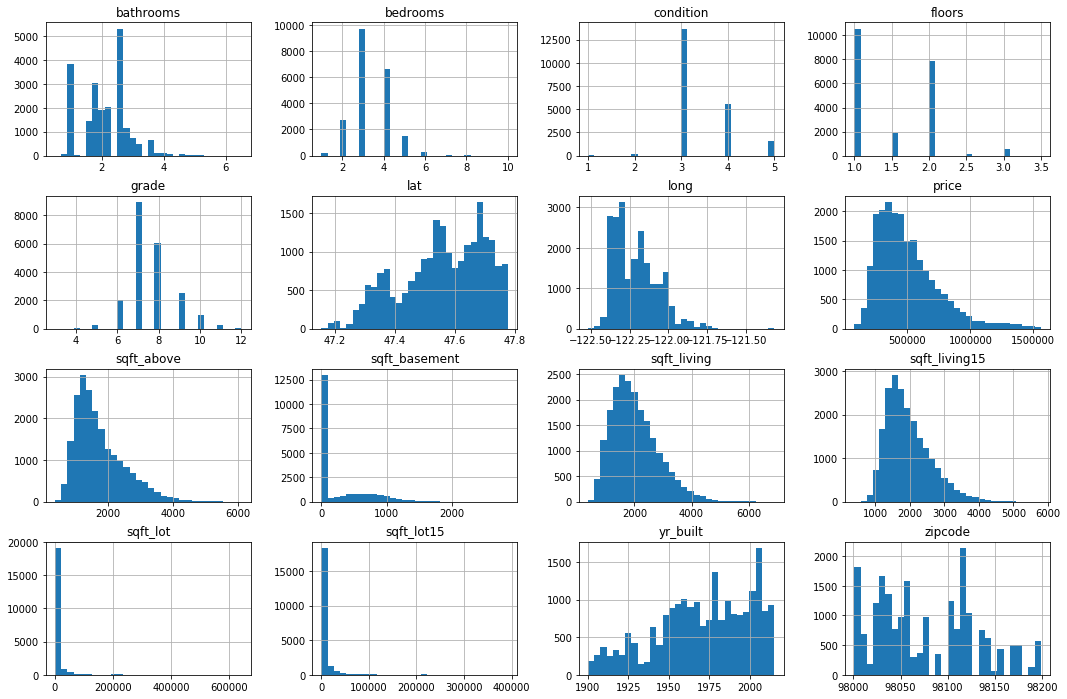

In [3]:
df.hist(bins=30, figsize=(18,12));

#### At first glance, many of these distributions look more normal than expected!

* `Bedrooms/Condition/Grade`: close to normal with positive skew and long right tail (bedrooms), weak representation below the mean (condition), while grade looks the most normal.
* `Bathrooms/Floors`: both look awkward.. will try log transformations or categorical binning to help normalize the data.
* `Lat/Long/Zipcode`: Our 3 geographical features would not have any expectation of normality but latitude and longitude almost look normal with the right and left tails chopped off, respectively.
* `Sqft_above/living/living15`: These 3 almost mirror the distribution of prices.. should be no surprise as square footage is a top determining factor for sale price.
* `Sqft_basement/lot/lot15`: The most un-normal looking distributions of the square footage features. This likely is due to a lower prevalance of basements in Seattle on average than other U.S. cities (less appropriate weather, soil, more prone to earthquake risk) - more than half of the properties in this dataset have no basement. In addition, there appear to be many properties with HUGE lots (farms? homes with a backyard forest?) in proportion to the living space.
* `Yr_built`: overrepresentation of newer homes.. spikes and valleys correlate with housing booms / slowdowns.

## Question 1: Are the TIME related features helpful in predicting our target (price) in this project?
* Our 3 time related features (date sold, year built, year renovated) may not be as helpful as they seem at first glance.
* It is generally correct that housing gets more expensive over time.. but that only applies when comparing the same property and its change in selling price over time. We do not have multiple price points nor a baseline, such as the price paid in the year it was built.
* Renovations may certainly add value reflected in a subsequent selling price, but we cannot infer that in our dataset when we have no idea the price before renovation nor if it increased square footage, added a floor, rooms, etc. We also had so little nonzero/null year renovation data that we dropped the column altogether.
* A more useful metric would be the home's AGE.

In [4]:
#Verify range of our selling dates
df.date = pd.to_datetime(df.date)
display(df.date.min(), df.date.max())

Timestamp('2014-05-02 00:00:00')

Timestamp('2015-05-27 00:00:00')

#### Our dataset has an extremely narrow range of sell dates (~1 year). Now let's create the new 'age' column

In [5]:
#Calculate the 'year fraction' of date sold then subtract the year built to get age in years
import datetime
df['age'] = (pd.DatetimeIndex(df.date).year + 
             ((pd.DatetimeIndex(df.date).month - 1) / 12) + 
             ((pd.DatetimeIndex(df.date).day / 365)) - df.yr_built)

#Drop 'date' and 'yr_built' columns
df = df.drop(labels=['date','yr_built'], axis=1)
df.sort_values(by='age')

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,age
id,,,,,,,,,,,,,,,,
6169901185,490000.0,5,3.50,4460,2975,3.0,3,10,3280,1180,98119,47.6313,-122.370,2490,4231,-0.611872
9126100346,350000.0,3,2.00,1380,3600,3.0,3,8,1380,0,98122,47.6074,-122.305,1480,3600,-0.536758
1250200495,455000.0,2,1.50,1200,1259,2.0,3,8,1000,200,98144,47.6001,-122.298,1320,1852,-0.517580
1832100030,597326.0,4,4.00,3570,8250,2.0,3,10,2860,710,98040,47.5784,-122.226,2230,10000,-0.514840
1257201420,595000.0,4,3.25,3730,4560,2.0,3,9,2760,970,98103,47.6725,-122.330,1800,4560,-0.475342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4232902615,819000.0,3,1.00,1300,3600,2.0,3,7,1300,0,98119,47.6345,-122.366,2510,4800,115.326712
7883604065,210000.0,2,1.00,1100,6000,1.5,4,6,1100,0,98108,47.5275,-122.323,1280,6000,115.336073
9187200045,625000.0,4,1.50,2120,5000,2.0,4,8,2120,0,98122,47.6024,-122.296,1830,5000,115.344292


#### Negative age values! Let's fix those.

In [6]:
#show rows from our raw_data set matching index numbers of negative ages
display(raw_data.set_index('id').loc[list(df[df.age<=0].index)].shape, raw_data.set_index('id').loc[list(df[df.age<=0].index)])

(11, 20)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
1832100030,6/25/2014,597326.0,4,4.00,3570,8250,2.0,0.0,0.0,3,10,2860,710.0,2015,NaN,98040,47.5784,-122.226,2230,10000
3076500830,10/29/2014,385195.0,1,1.00,710,6000,1.5,0.0,0.0,3,6,710,0.0,2015,NaN,98144,47.5756,-122.316,1440,4800
1250200495,6/24/2014,455000.0,2,1.50,1200,1259,2.0,0.0,0.0,3,8,1000,200.0,2015,NaN,98144,47.6001,-122.298,1320,1852
2770601530,8/26/2014,500000.0,2,2.25,1570,1269,2.0,NaN,0.0,3,9,1280,290.0,2015,NaN,98199,47.6514,-122.385,1570,6000
9126100346,6/17/2014,350000.0,3,2.00,1380,3600,3.0,NaN,0.0,3,8,1380,0.0,2015,0.0,98122,47.6074,-122.305,1480,3600
9126100765,8/1/2014,455000.0,3,1.75,1320,1014,3.0,0.0,0.0,3,9,1320,0.0,2015,0.0,98122,47.6047,-122.305,1380,1495
9310300160,8/28/2014,357000.0,5,2.50,2990,9240,2.0,0.0,0.0,3,8,2990,0.0,2015,0.0,98133,47.7384,-122.348,1970,18110
1257201420,7/9/2014,595000.0,4,3.25,3730,4560,2.0,0.0,0.0,3,9,2760,970.0,2015,0.0,98103,47.6725,-122.330,1800,4560
6058600220,7/31/2014,230000.0,3,1.50,1040,1264,2.0,0.0,0.0,3,9,900,140.0,2015,0.0,98144,47.5951,-122.301,1350,3000


### Only 11 properties from our dataset have this mistake of claiming to be sold in 2014 yet built in 2015.. since the fractional negative age values are so small we'll just round them to 0

In [7]:
df.age.loc[list(df[df.age<=0].index)] = 0
df.age.describe()

C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


count    21027.000000
mean        43.869825
std         29.285502
min          0.000000
25%         18.411416
50%         40.226941
75%         63.332763
max        115.366210
Name: age, dtype: float64

#### Excellent! We added a much more useful time related feature (age) in our regression model and dropped the date and yr_built columns.

In [10]:
#Find mean price of all properties either built or renovated in the last 15 years
df_new1 = raw_data.set_index('id')
df_new = df_new1.loc[df_new1[df_new1.yr_renovated>=2000].index]
df_new1 = df_new1.loc[df_new1[df_new1.yr_built>=2000].index]
df_new = pd.concat([df_new1,df_new]).drop_duplicates()
print(f'Recent homes mean price: {df_new.price.mean().round()}', f'#:{len(df_new)}')

#Remove these newer homes from our original dataset and recalculate mean
print(f"Older homes mean price: {raw_data.set_index('id').drop(df_new.index).price.mean().round()}")

Recent homes mean price: 634374.0 #:5134
Older homes mean price: 510958.0


#### Out of curiosity, we decided to do a quick comparison of newer homes (built/renovated in last 15 years, since 2000) and confirmed a ~$125k higher mean sales price. Makes sense!

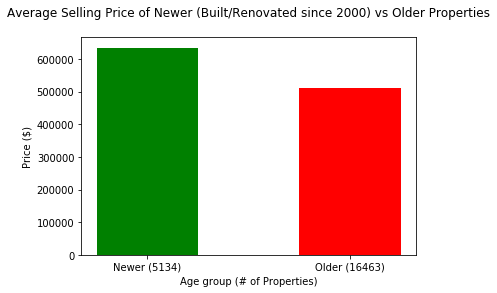

In [11]:
#Simple bar chart of above for presentation
newer = {'Newer (5134)': 0, 'Older (16463)': 0}
newer['Newer (5134)'] = df_new.price.mean()
newer['Older (16463)'] = raw_data.set_index('id').drop(df_new.index).price.mean()

plt.bar(newer.keys(), newer.values(), data=newer, width=0.5, color=['g','r'])
plt.title('Average Selling Price of Newer (Built/Renovated since 2000) vs Older Properties\n')
plt.xlabel('Age group (# of Properties)')
plt.ylabel('Price ($)')
plt.show;

## Question 2: Should we be concerned about multiple sales for the same property in such a short timeframe?
* We're going to guess yes - reselling properties in under 12 months would often indicate 'flipping' activity, which would contribute to 'bad pricing data' if the other features are identical.

In [12]:
#examine # of unique properties in the duplicated set
df_dup = raw_data.set_index('id')
df_dup.date = pd.to_datetime(df_dup.date)
df_dup = df_dup[df_dup.index.duplicated(keep=False)].sort_values(by=['id','date'], ascending=False)
display(df_dup, f'# of Unique properties: {len(df_dup.index.unique())}')

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
9834200885,2015-04-20,550000.0,4,2.50,2080,4080,1.0,0.0,0.0,5,7,1040,1040.0,1962,0.0,98144,47.5720,-122.290,1340,4080
9834200885,2014-07-17,360000.0,4,2.50,2080,4080,1.0,0.0,0.0,5,7,1040,1040.0,1962,0.0,98144,47.5720,-122.290,1340,4080
9834200305,2015-02-10,615000.0,3,1.00,1790,3876,1.5,0.0,0.0,5,7,1090,700.0,1904,0.0,98144,47.5750,-122.288,1360,4080
9834200305,2014-07-16,350000.0,3,1.00,1790,3876,1.5,0.0,0.0,5,7,1090,?,1904,0.0,98144,47.5750,-122.288,1360,4080
9828200460,2015-01-06,430000.0,2,1.00,700,4800,1.0,0.0,0.0,3,7,700,0.0,1922,0.0,98122,47.6147,-122.300,1440,4800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109200390,2014-08-20,245000.0,3,1.75,1480,3900,1.0,0.0,0.0,4,7,1480,0.0,1980,0.0,98023,47.2977,-122.367,1830,6956
7200179,2015-04-24,175000.0,2,1.00,840,12750,1.0,0.0,0.0,3,6,840,0.0,1925,NaN,98055,47.4840,-122.211,1480,6969
7200179,2014-10-16,150000.0,2,1.00,840,12750,1.0,0.0,0.0,3,6,840,0.0,1925,0.0,98055,47.4840,-122.211,1480,6969


'# of Unique properties: 176'

#### As evidenced above, these properties show different prices for identical features. We should combine them into a single row and replace the price (and age) with its mean values.
* Note that 176x2=352 (out of 353 total) so we have 1 property that appears 3x (was resold twice)

In [13]:
#create temporary dataframe with the unique index ids of duplicated properties to hold the mean price and age values
df_dup2 = pd.DataFrame(data=None, index=df_dup.index.unique(), columns=['price','age','1','2','3'])

for i in list(df_dup.index.unique()):
    df_dup2.price.loc[i] = df_dup.price.loc[i].mean().astype(float) 
    try: df_dup2.age.loc[i] = df.age.loc[i].mean().astype(float)
    except: pass #had to use try due to a property outlier dropped earlier
    
    #fill prices of each property instance in columns 1-3 out of curiosity to visualize differences
    for p in range(len(df_dup.loc[i])):
        df_dup2.loc[i][p+2] = df_dup.loc[i].iloc[p].price
        
df_dup2.price = df_dup2.price.astype('float64')
df_dup2.age = df_dup2.age.astype('float64')
df_dup2.sort_values(by=['3','age'], ascending=False).head(10)

,price,age,1,2,3
id,,,,,
795000620,132000.0,64.962329,157000,124000,115000
9136103130,557500.0,115.142808,685000,430000,NaN
3332000615,349500.0,112.057534,389000,310000,NaN
9834200305,482500.0,110.827283,615000,350000,NaN
3333002450,327500.0,108.791096,490000,165000,NaN
5249801440,410000.0,105.135388,570000,250000,NaN
1254200015,515000.0,105.116210,625000,405000,NaN
1781500435,417500.0,103.894977,575000,260000,NaN
3904100089,245000.0,102.901027,300000,190000,NaN


#### Wow, some properties had very significant (>$200k) sale price differences in less than a year timeframe! (5/2/2014 - 5/27/2015)
* This is very bad for our dataset when these 'identical feature' properties have such large price differences.
* As we may recall, the dropped 'yr_renovated' column's mode was 2014 (there's the houseflippers!).

In [14]:
#Get average profits for resold homes
profit = list()
for p in df_dup2.index:
    profit.append(df_dup2['1'].loc[p] - df_dup2['2'].loc[p])
profit.append(124000 - 115000) #accounting for the single 3rd sale
np.mean(profit)

135796.05084745763

In [15]:
#Quick verify that the values for every feature (except price and age) are truly identical for each duplicated property
#Left side compares total number of duplicated properties with right side which grabs all duplicated, drops price/age
#columns then runs duplicated function again on all columns (rather than just index) to confirm same sum
df.index.duplicated(keep=False).sum() == df[df.index.duplicated(keep=False)].drop(['price',
                                                                                   'age'], axis=1).duplicated(keep=False).sum()

True

In [16]:
#Drop all the duplicates from our dataset (default option keep='first' will retain the 1st copy of each duplicate)
df = df.reset_index().drop_duplicates(subset=['id']) #is it not possible to use drop_duplicates() using subset=index?
df = df.set_index('id')

#replace price and age with mean values
for i in df_dup2.index:
    if i in df.index: #filter for outliers properties already removed to prevent error
        df.price.loc[i] = df_dup2.price.loc[i]
        df.age.loc[i] = df_dup2.age.loc[i]
display(df.head(3), df.shape)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,age
id,,,,,,,,,,,,,,,,
7129300520,221900.0,3,1.00,1180,5650,1.0,3,7,1180,0,98178,47.5112,-122.257,1340,5650,59.785616
6414100192,538000.0,3,2.25,2570,7242,2.0,3,7,2170,400,98125,47.7210,-122.319,1690,7639,63.941324
5631500400,180000.0,2,1.00,770,10000,1.0,3,6,770,0,98028,47.7379,-122.233,2720,8062,82.151826


(20853, 16)

#### Awesome! Now all of the 'misleading duplicate' data was removed and their price/age appropriately updated with their means.
* To recap, we removed all 'duplicate' properties exhibiting different sell dates and prices for identical features and merged all instances into a single mean price and age.

## Question 3: Should we be concerned about urban/rural properties and their locations?
* Let's dive deeper into square footages, location features

In [17]:
#Take a look at the 5 point statistics for square footage, location columns only
df.drop(labels=['bedrooms','bathrooms','floors','condition','grade','age']
        ,axis=1).describe().round(3)

,price,sqft_living,sqft_lot,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15
count,20853.000,20853.000,20853.000,20853.000,20853.000,20853.000,20853.000,20853.000,20853.000,20853.000
mean,502773.632,2026.800,14215.267,1747.706,279.094,98078.147,47.559,-122.213,1956.950,12345.953
std,250572.393,825.926,33162.255,763.732,423.106,53.293,0.140,0.141,650.524,24790.761
min,78000.000,370.000,520.000,370.000,0.000,98001.000,47.156,-122.519,399.000,651.000
25%,320000.000,1410.000,5000.000,1190.000,0.000,98033.000,47.468,-122.329,1480.000,5058.000
50%,445000.000,1890.000,7526.000,1540.000,0.000,98065.000,47.570,-122.230,1820.000,7560.000
75%,625000.000,2500.000,10423.000,2160.000,540.000,98118.000,47.679,-122.123,2320.000,9948.000
max,1560000.000,6900.000,641203.000,6110.000,2850.000,98199.000,47.778,-121.315,5790.000,392040.000


#### *Our 3 location variables (lat, long, zipcode) do not currently look useful with such narrow ranges. However, we did notice that during our data cleaning that latitude was the most correlated to price among the 3.*

In [18]:
pd.DataFrame(df.corr().price)[10:13]

,price
zipcode,-0.030684
lat,0.396372
long,0.048804


#### *Latitude has the highest price correlation and the most distribution normality so we will keep this as the only location related feature.*
* *Note: mapping these properties geographically could help narrow down which specific neighborhoods are 'hot' - which greatly influences higher sale prices. Was not able to explore in this notebook but would love to in the future. More specifically - a new 'demand rating' column could be created that examines clustering of sales, geography, neighbors, etc.*

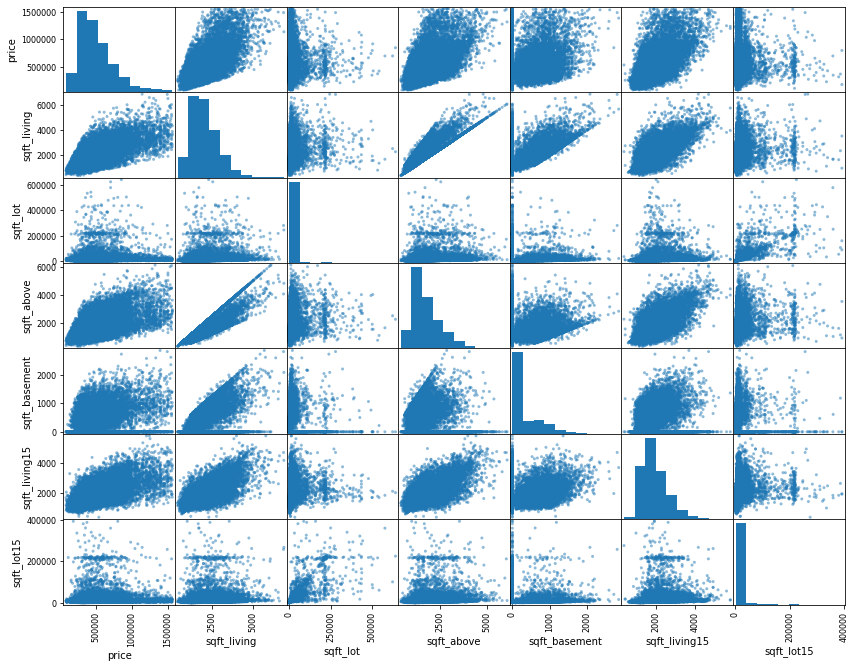

In [19]:
#Drop the other location features
df = df.drop(labels=['long','zipcode'],axis=1)

#Take a look at scatter matrix of sqft features to examine correlations, distributions
pd.plotting.scatter_matrix(df.drop(labels=['bedrooms','bathrooms','floors','condition','grade','lat','age'],
                                   axis=1),figsize=(14,11));

#### Let's break down further the significance of each different type of square footage feature:
* **Living**: total square footage of the home's interior ('livable') space, cumulatively added for each floor. Note that the number of floors has the effect of significantly increasing the ratio of square feet living vs the total lot. The house 'footprint' on the lot stays the same while living square footage nearly doubles with every added floor. We actually have several hundred properties where sqft_living is greater than sqft_lot!
* **Lot**:  total square footage of the 'lot' or surrounding land belonging to the property, which can vary tremendously for similarly sized homes. The most obvious difference would be between rural vs urban homes. The smaller that a property's living space is in proportion to its entire lot, the more likely it would be considered rural. This is reflected in less uniformity, density of homes, farther neighbors all contributing to higher unpredictability of price. Urban homes have closer neighbors, smaller lots and price prediction is often easier due to higher conformity of both features and price.
* **Above**: square footage of house apart from basement (or living - basement). Above = living if there is no basement.
* **Basement**: square footage of the basement; note that more than half of the homes in our dataset have no basement.
* **Living15/Lot15**: square footage of interior living space / lot size for the nearest 15 neighbors (assuming mean).

***As expected, many of these sqft features correlate with each other and most would have to be eliminated to remove multicollinearity from our model. However, we may be able to create new features based on what we can find. Let's first look at basements.***

In [20]:
#Confirm exactly how much of our dataset has no basement
print(f'% of our dataset with no basements: {len(df[df.sqft_basement<1]) / len(df) * 100}')
print(f'Yes basement price median: {df[df.sqft_basement>0].price.median()}')
print(f'No basement price median: {df[df.sqft_basement<1].price.median()}')

#Get 5 point statistics for properties with basements vs no basements
display(df[df.sqft_basement>0].describe().round(2), df[df.sqft_basement<1].describe().round(2))

% of our dataset with no basements: 61.31012324365799
Yes basement price median: 500000.0
No basement price median: 408000.0


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,lat,sqft_living15,sqft_lot15,age
count,8068.00,8068.00,8068.00,8068.00,8068.00,8068.00,8068.00,8068.00,8068.00,8068.00,8068.00,8068.00,8068.00,8068.00
mean,559938.54,3.53,2.22,2224.45,12568.32,1.30,3.52,7.64,1503.09,721.36,47.58,1971.94,10939.84,49.99
std,265333.49,0.94,0.72,800.94,27769.72,0.47,0.69,0.98,593.34,379.03,0.12,600.39,20872.52,28.20
min,100000.00,1.00,0.50,680.00,572.00,1.00,1.00,4.00,480.00,10.00,47.18,460.00,651.00,0.00
25%,370000.00,3.00,1.75,1660.00,4946.50,1.00,3.00,7.00,1100.00,440.00,47.52,1550.00,5000.00,31.79
50%,500000.00,3.00,2.25,2080.00,7416.50,1.00,3.00,7.00,1350.00,700.00,47.59,1860.00,7500.00,48.52
75%,678760.00,4.00,2.50,2610.00,10300.00,1.50,4.00,8.00,1720.00,950.00,47.68,2262.50,9832.00,67.70
max,1560000.00,10.00,6.50,6900.00,542322.00,3.00,5.00,12.00,5400.00,2850.00,47.78,5790.00,386812.00,115.30


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,lat,sqft_living15,sqft_lot15,age
count,12785.00,12785.00,12785.00,12785.00,12785.00,12785.00,12785.00,12785.00,12785.00,12785.0,12785.00,12785.00,12785.00,12785.00
mean,466699.60,3.24,2.00,1902.07,15254.58,1.60,3.34,7.58,1902.07,0.0,47.54,1947.49,13233.28,39.85
std,233713.95,0.84,0.72,817.10,36116.05,0.55,0.61,1.16,817.10,0.0,0.15,680.12,26935.05,29.30
min,78000.00,1.00,0.50,370.00,520.00,1.00,1.00,3.00,370.00,0.0,47.16,399.00,659.00,0.00
25%,299000.00,3.00,1.50,1270.00,5100.00,1.00,3.00,7.00,1270.00,0.0,47.43,1440.00,5160.00,14.34
50%,408000.00,3.00,2.00,1730.00,7598.00,2.00,3.00,7.00,1730.00,0.0,47.55,1800.00,7615.00,32.64
75%,583000.00,4.00,2.50,2410.00,10495.00,2.00,4.00,8.00,2410.00,0.0,47.68,2370.00,10005.00,60.36
max,1560000.00,8.00,5.75,6110.00,641203.00,3.50,5.00,12.00,6110.00,0.0,47.78,5790.00,392040.00,115.36


#### Here are some conclusions we can make:
1. For the homes having a basement vs not - the price ranges and standard deviations are not too different - but the price of homes with a basement is almost 25% higher. Unexpectedly, the mean # of floors is actually higher in the no basement group but it is not clear if basements get counted as 1 floor (per Google, in the US they are usually not). Living space is ~10% more for homes with basements, as expected.
2. All other features do not appear to differ much. It seems having a basement should result in a $100k higher price, on average.
3. Living and living15 are well correlated with price and each other. We will be choosing the better feature and dropping the other to eliminate their multicollinearity effect.
4. Basement, lot and lot15 as evidenced by their histograms, indicate a huge overrepresentation of lower values. As confirmed, over 60% of our properties have no basement.
5. Lets create a new binary variable: basement(yes/no). Considering that living already includes the area of the basement, we are not truly 'removing' the basement square footage measurement.

In [21]:
#Create new basement column where 1=yes, 0=no and drop sqft_basement
df['basement'] = df.sqft_basement.apply(lambda x: 1 if x>0 else 0)
df = df.drop(labels='sqft_basement',axis=1)

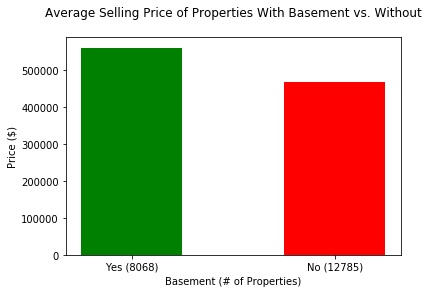

In [22]:
#Simple bar chart of above for presentation
basement = {'Yes (8068)': 0, 'No (12785)': 0}
basement['Yes (8068)'] = df[df.basement==1].price.mean()
basement['No (12785)'] = df[df.basement==0].price.mean()

plt.bar(basement.keys(), basement.values(), data=basement, width=0.5, color=['g','r'])
plt.title('Average Selling Price of Properties With Basement vs. Without\n')
plt.xlabel('Basement (# of Properties)')
plt.ylabel('Price ($)')
plt.show;

### Examining 'urban' vs 'rural' properties
* ***Since equivalent feature urban properties sell for more than rural ones, we will be determining the threshold at which the greatest price difference is evident. In general, most urban properties do not drop below a 1:2 ratio of living:lot square footage.***

In [23]:
#Create a new column 'ratio' (sqft_living/lot) which we will use to help determine the ratio threshold
df['ratio'] = (df.sqft_living / df.sqft_lot).round(2)
df.ratio.describe().round(2)

count    20853.00
mean         0.32
std          0.27
min          0.00
25%          0.16
50%          0.25
75%          0.41
max          4.65
Name: ratio, dtype: float64

#### Cool! Our mean of 0.32 is very close to our stated assumed 1:2 ratio. Now let's iterate through different ratios to find out where the average price difference between the 2 groups is the greatest.

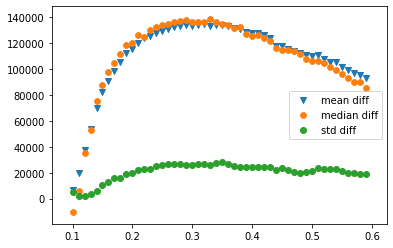

In [24]:
#dft to be used for recording average price differences between the 2 groups at given ratio threshold
dft = pd.DataFrame(index=range(0,len(df)),columns=['threshold','mean_diff','median_diff','std_diff'])
x = 0 #counter

#collect the average price differences between each group over/under given threshold and create scatter plot
#we should expect to see the differences peak where our correct threshold should be
for t in np.arange(0.1, 0.6, .01): #let's start with between 0.1 and 0.6 and examine at increments of 0.01
    dft.threshold[x] = t.round(2)
    dft.mean_diff[x] = (df[df.ratio>=t].price.mean() - df[df.ratio<t].price.mean())
    dft.median_diff[x] = (df[df.ratio>=t].price.median() - df[df.ratio<t].price.median())
    dft.std_diff[x] = (df[df.ratio>=t].price.std() - df[df.ratio<t].price.std())
    x+=1
plt.scatter(dft.threshold,dft.mean_diff, marker='v', label='mean diff')
plt.scatter(dft.threshold,dft.median_diff, marker='8', label='median diff')
plt.scatter(dft.threshold,dft.std_diff, label='std diff')
plt.legend()
plt.show()

#### Our standard deviation is holding steady for both groups which is good. One can imagine that properties with 10x+ lot square footage vs living (<0.1 ratio) are likely to be large farms, owning undeveloped land and/or farther away from cities, where pricing per sqft peaks.

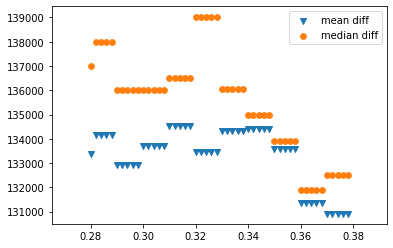

,threshold,mean_diff,median_diff,std_diff
24,0.328,133438,139000,NaN
20,0.32,133438,139000,NaN
21,0.322,133438,139000,NaN
22,0.324,133438,139000,NaN
23,0.326,133438,139000,NaN


In [25]:
#Run it again with more granularity where the peak appears to be
dft = pd.DataFrame(index=range(0,len(df)),columns=['threshold','mean_diff','median_diff','std_diff'])
x = 0 #counter
for t in np.arange(0.28, 0.38, .002): #from .28 to .38 with increments of .002
    dft.threshold[x] = t.round(3)
    dft.mean_diff[x] = (df[df.ratio>=t].price.mean() - df[df.ratio<t].price.mean())
    dft.median_diff[x] = (df[df.ratio>=t].price.median() - df[df.ratio<t].price.median())
    #removed std as it throws off our plot scale
    x+=1
plt.scatter(dft.threshold,dft.mean_diff, marker='v', label='mean diff')
plt.scatter(dft.threshold,dft.median_diff, marker='8', label='median diff')
plt.legend()
plt.show()
#show values of top threshold levels with highest median difference
dft.sort_values(by='median_diff', ascending=False).head()

#### It appears we reached a level of granularity where 'bins' are forming. The 0.32 ratio appears to be the optimal threshold where we see the greatest average price difference between the 2 groups (~$135k). This should be appropriate for separating what would be considered:
* Rural (<0.32 sqft_living/lot ratio)
* Urban (>=0.32 sqft_living/lot ratio).

In [27]:
#Rename column 'ratio' to 'urban' after converting values to 1 if >= 0.32 and 0 if < 0.32
df.ratio = df.ratio.map(lambda x: 1 if x >= .32 else 0)
df = df.rename({'ratio':'urban'}, axis='columns')

#Compare both groups to observe differences in sqft_lot,15
display(f'Urban median: {df[df.urban==1].price.median()}', f'Rural median: {df[df.urban==0].price.median()}')
display(df[df.urban==1].describe().round(2), df[df.urban==0].describe().round(2))

#Drop sqft_lot,15
df = df.drop(labels=['sqft_lot','sqft_lot15'],axis=1)

'Urban median: 536500.0'

'Rural median: 400000.0'

,price,bedrooms,bathrooms,sqft_living,floors,condition,grade,sqft_above,lat,sqft_living15,age,basement,urban
count,7671.00,7671.00,7671.00,7671.00,7671.00,7671.00,7671.00,7671.00,7671.00,7671.00,7671.00,7671.00,7671.0
mean,587823.35,3.51,2.42,2281.74,1.83,3.28,7.95,1958.33,47.58,2034.95,35.27,0.45,1.0
std,258664.85,0.93,0.67,811.13,0.52,0.59,0.99,783.13,0.12,664.47,36.00,0.50,0.0
min,90000.00,1.00,0.50,550.00,1.00,1.00,4.00,500.00,47.19,460.00,0.00,0.00,1.0
25%,395000.00,3.00,2.00,1650.00,1.50,3.00,7.00,1340.00,47.53,1530.00,8.26,0.00,1.0
50%,536500.00,3.00,2.50,2190.00,2.00,3.00,8.00,1800.00,47.60,1890.00,14.87,0.00,1.0
75%,720000.00,4.00,2.75,2790.00,2.00,3.00,9.00,2490.00,47.67,2440.00,64.47,1.00,1.0
max,1560000.00,10.00,6.50,6630.00,3.50,5.00,12.00,6110.00,47.78,5790.00,115.34,1.00,1.0


,price,bedrooms,bathrooms,sqft_living,floors,condition,grade,sqft_above,lat,sqft_living15,age,basement,urban
count,13182.00,13182.00,13182.00,13182.00,13182.00,13182.00,13182.00,13182.00,13182.00,13182.00,13182.00,13182.00,13182.0
mean,453280.66,3.26,1.89,1878.44,1.29,3.48,7.40,1625.14,47.55,1911.56,48.72,0.35,0.0
std,231805.68,0.85,0.70,797.79,0.43,0.67,1.11,724.59,0.15,637.92,23.18,0.48,0.0
min,78000.00,1.00,0.50,370.00,1.00,1.00,3.00,370.00,47.16,399.00,0.00,0.00,0.0
25%,285000.00,3.00,1.00,1300.00,1.00,3.00,7.00,1130.00,47.43,1460.00,30.88,0.00,0.0
50%,400000.00,3.00,1.75,1750.00,1.00,3.00,7.00,1420.00,47.55,1790.00,47.39,0.00,0.0
75%,555548.75,4.00,2.50,2280.00,1.50,4.00,8.00,1940.00,47.69,2250.00,62.85,1.00,0.0
max,1560000.00,10.00,6.00,6900.00,3.00,5.00,12.00,6070.00,47.78,5790.00,115.36,1.00,0.0


#### As we can see, there are quite significantly statistical differences between these 2 groups:
1. Average price difference of ~$135k (with very similar std - 258k vs 231k)
2. Mean sqft_living is ~400sqft higher for urban with min/max ranges and std very similar for both. Sqft_living15 closely mirrors living as expected.
3. The differences really begin to show in sqft_lot,15 where for urban homes these 2 columns are similar and highest values are 15.4k, 70k, respectively. For rural homes, the mean sqft_lot is ***4x greater*** and std is ***almost 20x greater;*** for sqft_lot15, the rural mean is ***over 3x*** while std is ***almost 15x.*** In addition, the max sqft_lot,15 values for rural are 641k and 392k respectively, or approximately ***40x and 5x greater.*** Note that an even greater spread for rural homes might've been mitigated with removed outliers during our earlier data cleaning.
4. The average age of urban homes sold is ~13.5 years younger. Makes sense as the number of urban homes built outpaces rural homes over time.

***To summarize, we dropped columns 'sqft_lot', 'sqft_lot15' and 'sqft_basement'. We created 2 new column features: urban (1=urban, 0=rural) and basement (1=yes,0=no).***

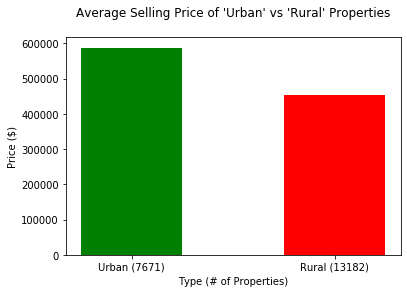

In [28]:
#Simple bar chart of above for presentation
urban = {'Urban (7671)': 0, 'Rural (13182)': 0}
urban['Urban (7671)'] = df[df.urban==1].price.mean()
urban['Rural (13182)'] = df[df.urban==0].price.mean()

plt.bar(urban.keys(), urban.values(), data=urban, width=0.5, color=['g','r'])
plt.title("Average Selling Price of 'Urban' vs 'Rural' Properties\n")
plt.xlabel('Type (# of Properties)')
plt.ylabel('Price ($)')
plt.show;

## Building our Regression Model - Feature Selection, Transformations

In [29]:
#Let's do a quick check to see if our model has improved
display(pd.DataFrame(df.corr().price.sort_values(ascending=False))) #show features ranked by price correlation
model = sm.OLS(df.price, df.drop('price', axis=1)).fit()
model.summary()

,price
price,1.000000
grade,0.670159
sqft_living,0.662816
sqft_living15,0.591548
sqft_above,0.564185
bathrooms,0.492493
lat,0.396372
bedrooms,0.325155
floors,0.277535
urban,0.258932


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.925
Model:                            OLS   Adj. R-squared (uncentered):              0.925
Method:                 Least Squares   F-statistic:                          2.154e+04
Date:                Mon, 02 Mar 2020   Prob (F-statistic):                        0.00
Time:                        07:29:24   Log-Likelihood:                     -2.7860e+05
No. Observations:               20853   AIC:                                  5.572e+05
Df Residuals:                   20841   BIC:                                  5.573e+05
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
bedrooms      -2.089e+04   1555.130    -13.434      0.000   -2.39e+04   -1.78e+04
bathrooms      2.764e+04   2597.316     10.642      0.000    2.25e+04    3.27e+04
sqft_living      78.0782      5.079     15.373      0.000      68.123      88.033
floors         2.899e+04   3039.375      9.537      0.000     2.3e+04    3.49e+04
condition      1.956e+04   1793.598     10.904      0.000     1.6e+04    2.31e+04
grade          1.058e+05   1667.511     63.443      0.000    1.03e+05    1.09e+05
sqft_above       -2.3342      5.527     -0.422      0.673     -13.167       8.499
lat           -1.779e+04    270.097    -65.860      0.000   -1.83e+04   -1.73e+04
sqft_living15    64.7505      2.721     23.797      0.000      59.417      70.084
age            3089.6738     49.294     62.679      0.000    2993.054    3186.294
basement        2.83e+04   4168.572      6.790      0.000    2.01e+04    3.65e+04
urban          5.558e+04   2659.500     20.898      0.000    5.04e+04    6.08e+04
==============================================================================
Omnibus:                     3073.322   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8111.674
Skew:                           0.817   Prob(JB):                         0.00
Kurtosis:                       5.582   Cond. No.                     1.40e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.4e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### R2 went down slightly, skew/kurtosis got better and condition num improved tremendously. It seems sqft_above is now reporting a huge p-value. Let's drop it and our 2 weakest correlated features.

In [30]:
df = df.drop(labels=['condition','age','sqft_above'], axis=1)

### Log Transformations

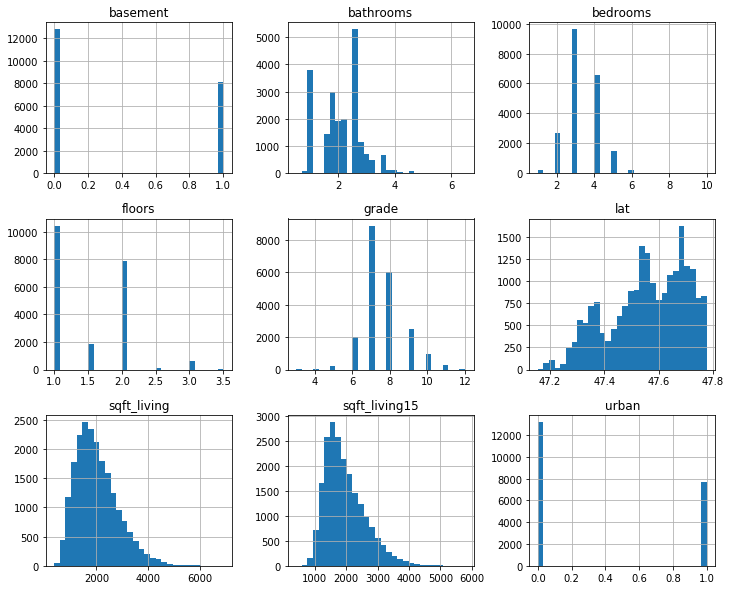

In [31]:
#View 'before' histograms
df.drop(labels='price',axis=1).hist(bins=30,figsize=(12,10));

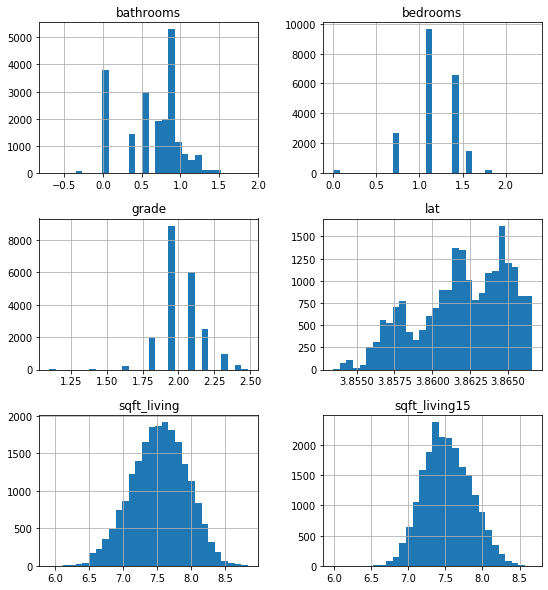

In [32]:
#df_log to store values of log transformed features
df_log = pd.DataFrame(index=df.index)
df_log['price'] = df['price']
for col in df.drop(labels=['price','floors','urban','basement'],axis=1).columns:
    df_log[col] = np.log(df[col])

#View 'after' histograms to see if normality has improved
df_log.drop(labels='price',axis=1).hist(bins=30,figsize=(9,10));

#### Both sqft features improved to nice looking normal distributions! Bedrooms/bathrooms look better and grade appeared to worsen (negative skew and left tail now) while lat looks relatively unchanged. Let's confirm these changes to normality using the Jarque-Bera Test.

In [33]:
#create function to run JB Test and print results
def JBTest(data, col):
    jb = ['Jarque-Bera','Prob','Skew', 'Kurtosis']
    f = 'price~'+col
    model = smf.ols(formula=f, data=data).fit()
    test = sms.jarque_bera(model.resid)
    print(list(zip(jb, test)))

for col in df.drop(labels=['price','floors','urban','basement'],axis=1).columns:
    print('Before: ',col)
    JBTest(df, col)
    print('After: ',col)
    JBTest(df_log, col)
    print('\n')

Before:  bedrooms
[('Jarque-Bera', 8070.082489163876), ('Prob', 0.0), ('Skew', 1.1884430534312473), ('Kurtosis', 4.907453701010011)]
After:  bedrooms
[('Jarque-Bera', 7987.782652845734), ('Prob', 0.0), ('Skew', 1.1970084126253715), ('Kurtosis', 4.8606264082686215)]


Before:  bathrooms
[('Jarque-Bera', 6595.319138438341), ('Prob', 0.0), ('Skew', 1.0730677310356458), ('Kurtosis', 4.727641357399218)]
After:  bathrooms
[('Jarque-Bera', 6854.387990546288), ('Prob', 0.0), ('Skew', 1.1146443680997136), ('Kurtosis', 4.708531434032563)]


Before:  sqft_living
[('Jarque-Bera', 5756.964847598823), ('Prob', 0.0), ('Skew', 0.9096838811189133), ('Kurtosis', 4.820898054377693)]
After:  sqft_living
[('Jarque-Bera', 5113.384154123508), ('Prob', 0.0), ('Skew', 0.9360664379495341), ('Kurtosis', 4.542783698712398)]


Before:  grade
[('Jarque-Bera', 6719.125393070337), ('Prob', 0.0), ('Skew', 1.0016618733436922), ('Kurtosis', 4.9286851328852626)]
After:  grade
[('Jarque-Bera', 6427.706114166815), ('Prob',

#### It seems JB scores showed some things differently than what we could observe from the histograms.. bedrooms got slightly better while bathrooms got worse! Both sqft features improved and grade improved while lat remained basically unchanged. We will go ahead and use the log transformed values for bedrooms, grade, and sqft_living,15. Let's combine these newly transformed variables into a new dataframe.

In [34]:
#Using df_model to combine transformed features
df_model = df.copy() 
for col in ['bedrooms','sqft_living','sqft_living15']: #took out grade as non log transformed fared better in model
    df_model[col] = df_log[col]

### Categorical One Hot Encoding and Binning: Floors

In [35]:
floors_bins = pd.cut(df.floors, [1,1.5,3.5]) #create 2 bins initially, 1 will be retained
floors_bins = floors_bins.cat.as_unordered()
df_model.floors = floors_bins
df_model.floors = df_model.floors.cat.codes
floors_dummy = pd.get_dummies(floors_bins, prefix='floors', drop_first=True)

#Drop floor column and add floor bin
df_model = df_model.drop('floors', axis=1)
df_model = pd.concat([df_model, floors_dummy], axis=1)
df_model.head()

,price,bedrooms,bathrooms,sqft_living,grade,lat,sqft_living15,basement,urban,"floors_(1.5, 3.5]"
id,,,,,,,,,,
7129300520,221900.0,1.098612,1.00,7.073270,7,47.5112,7.200425,0,0,0
6414100192,538000.0,1.098612,2.25,7.851661,7,47.7210,7.432484,1,1,1
5631500400,180000.0,0.693147,1.00,6.646391,6,47.7379,7.908387,0,0,0
2487200875,604000.0,1.386294,3.00,7.580700,7,47.5208,7.215240,1,1,0
1954400510,510000.0,1.098612,2.00,7.426549,8,47.6168,7.495542,0,0,0


### Min-Max Scaling and Mean Normalization
* Perform min-max scaling on lat and mean normalization on bathrooms, grade, sqft_living,15

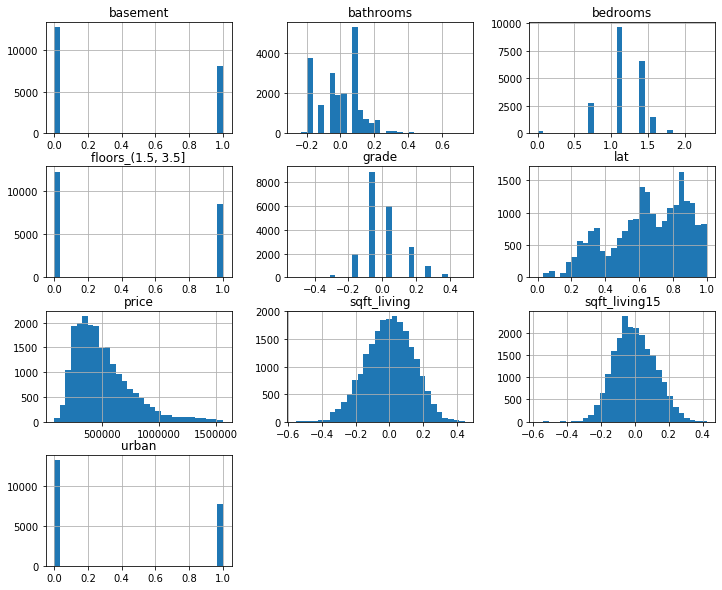

In [36]:
#Min-max scaling for lat
df_model['lat'] = (df_model['lat'] - df_model['lat'].min()) / (df_model['lat'].max() - df_model['lat'].min())

#Mean normalization for the others
for col in ['bathrooms','grade','sqft_living','sqft_living15']:
    df_model[col] = (df_model[col] - df_model[col].mean()) / (df_model[col].max() - df_model[col].min())

df_model.hist(bins=30,figsize=(12,10)); #view histograms again

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.920
Model:                            OLS   Adj. R-squared (uncentered):              0.919
Method:                 Least Squares   F-statistic:                          2.646e+04
Date:                Mon, 02 Mar 2020   Prob (F-statistic):                        0.00
Time:                        07:30:23   Log-Likelihood:                     -2.7939e+05
No. Observations:               20853   AIC:                                  5.588e+05
Df Residuals:                   20844   BIC:                                  5.589e+05
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
bedrooms           1.479e+05   2670.404     55.394      0.000    1.43e+05    1.53e+05
bathrooms         -1.023e+05   1.52e+04     -6.751      0.000   -1.32e+05   -7.26e+04
sqft_living        2.028e+05   1.63e+04     12.460      0.000    1.71e+05    2.35e+05
grade              8.293e+05   1.48e+04     55.917      0.000       8e+05    8.58e+05
lat                4.584e+05   4578.550    100.118      0.000    4.49e+05    4.67e+05
sqft_living15      3.323e+05   1.47e+04     22.619      0.000    3.04e+05    3.61e+05
basement           3.697e+04   2644.381     13.980      0.000    3.18e+04    4.22e+04
urban              4.519e+04   2689.557     16.800      0.000    3.99e+04    5.05e+04
floors_(1.5, 3.5] -1.398e+04   3178.151     -4.400      0.000   -2.02e+04   -7754.754
==============================================================================
Omnibus:                     3866.379   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9300.899
Skew:                           1.043   Prob(JB):                         0.00
Kurtosis:                       5.521   Cond. No.                         28.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,price
price,1.000000
grade,0.670159
sqft_living,0.624292
sqft_living15,0.567353
bathrooms,0.492493
lat,0.396372
bedrooms,0.315796
"floors_(1.5, 3.5]",0.275612
urban,0.258932
basement,0.181234


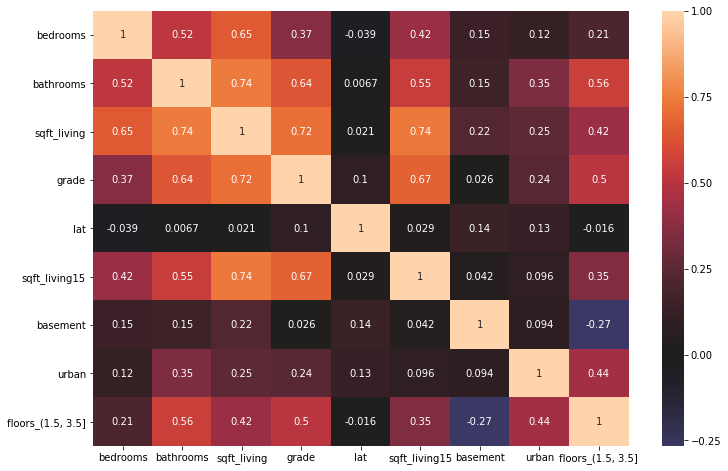

In [37]:
#Check for further changes to model
model = sm.OLS(df_model.price, df_model.drop('price', axis=1)).fit()
display(model.summary())

#Rank features by price correlation and view heatmap again 
display(pd.DataFrame(df_model.corr().price.sort_values(ascending=False)))
plt.figure(figsize=(12,8))
sns.heatmap(df_model.drop('price',axis=1).corr(), center=0, annot=True)
#Workaround for a bug that cut off half of the top and bottom cells
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show;

#### Condition number dropped like a stone! Let's go ahead and drop bathrooms/sqft_living15 (highest multicollinearity with other features balanced with price correlation ranking)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.917
Model:                            OLS   Adj. R-squared (uncentered):              0.917
Method:                 Least Squares   F-statistic:                          3.305e+04
Date:                Mon, 02 Mar 2020   Prob (F-statistic):                        0.00
Time:                        07:30:34   Log-Likelihood:                     -2.7967e+05
No. Observations:               20853   AIC:                                  5.593e+05
Df Residuals:                   20846   BIC:                                  5.594e+05
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
bedrooms           1.494e+05   2703.140     55.271      0.000    1.44e+05    1.55e+05
sqft_living        3.192e+05    1.3e+04     24.616      0.000    2.94e+05    3.45e+05
grade              9.069e+05   1.43e+04     63.322      0.000    8.79e+05    9.35e+05
lat                  4.7e+05   4577.073    102.686      0.000    4.61e+05    4.79e+05
basement           2.808e+04   2639.826     10.636      0.000    2.29e+04    3.33e+04
urban              3.446e+04   2685.515     12.833      0.000    2.92e+04    3.97e+04
floors_(1.5, 3.5] -1.992e+04   3061.221     -6.507      0.000   -2.59e+04   -1.39e+04
==============================================================================
Omnibus:                     3921.933   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9534.472
Skew:                           1.053   Prob(JB):                         0.00
Kurtosis:                       5.558   Cond. No.                         24.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,price
price,1.000000
grade,0.670159
sqft_living,0.624292
lat,0.396372
bedrooms,0.315796
"floors_(1.5, 3.5]",0.275612
urban,0.258932
basement,0.181234


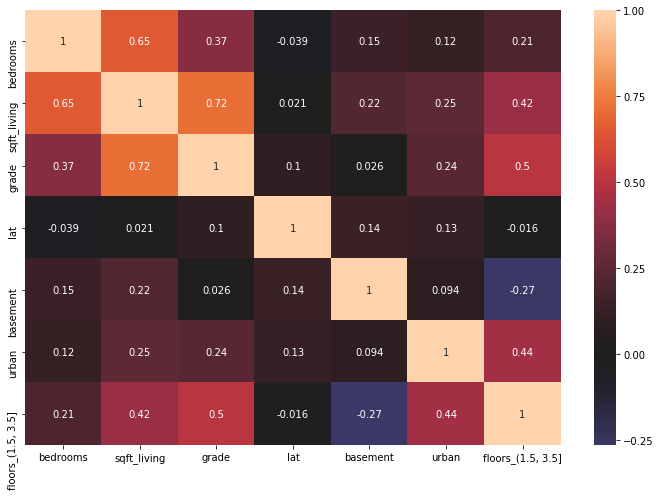

In [38]:
df_model = df_model.drop(labels=['bathrooms','sqft_living15'],axis=1)

#Check again to see changes to model
model = sm.OLS(df_model.price, df_model.drop('price', axis=1)).fit()
display(model.summary())
#Rank features by price correlation and view heatmap again 
display(pd.DataFrame(df_model.corr().price.sort_values(ascending=False)))
plt.figure(figsize=(12,8))
sns.heatmap(df_model.drop('price',axis=1).corr(), center=0, annot=True)
#Workaround for a bug that cut off half of the top and bottom cells
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show;

#### Looks like we'll have to ax bedrooms and grade to eliminate final bits of multicollinearity.

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.895
Model:                            OLS   Adj. R-squared (uncentered):              0.895
Method:                 Least Squares   F-statistic:                          3.544e+04
Date:                Mon, 02 Mar 2020   Prob (F-statistic):                        0.00
Time:                        07:30:43   Log-Likelihood:                     -2.8219e+05
No. Observations:               20853   AIC:                                  5.644e+05
Df Residuals:                   20848   BIC:                                  5.644e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
sqft_living        9.514e+05   1.05e+04     90.742      0.000    9.31e+05    9.72e+05
lat                 6.67e+05   3227.173    206.675      0.000    6.61e+05    6.73e+05
basement           3.852e+04   2887.223     13.340      0.000    3.29e+04    4.42e+04
urban              2.154e+04   3023.820      7.125      0.000    1.56e+04    2.75e+04
floors_(1.5, 3.5]  6.715e+04   3186.822     21.070      0.000    6.09e+04    7.34e+04
==============================================================================
Omnibus:                     2313.559   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4609.806
Skew:                           0.716   Prob(JB):                         0.00
Kurtosis:                       4.804   Cond. No.                         8.81
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,price
price,1.000000
sqft_living,0.624292
lat,0.396372
"floors_(1.5, 3.5]",0.275612
urban,0.258932
basement,0.181234


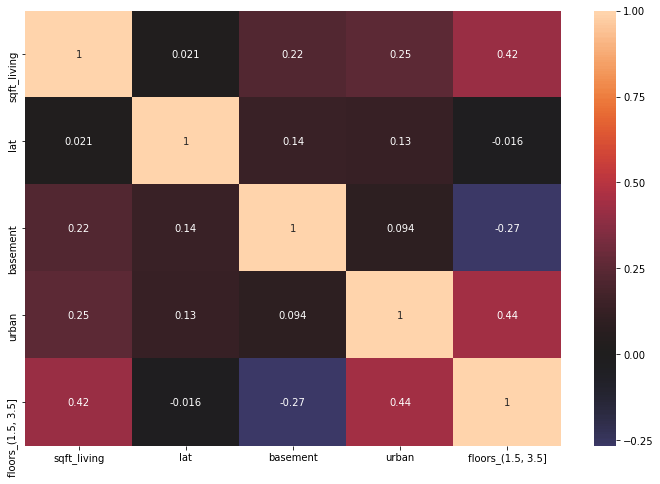

In [39]:
df_model = df_model.drop(labels=['bedrooms','grade'],axis=1)

#Check to see changes to model
model = sm.OLS(df_model.price, df_model.drop('price', axis=1)).fit()
display(model.summary())
#Rank features by price correlation and view heatmap again 
display(pd.DataFrame(df_model.corr().price.sort_values(ascending=False)))
plt.figure(figsize=(12,8))
sns.heatmap(df_model.drop('price',axis=1).corr(), center=0, annot=True)
#Workaround for a bug that cut off half of the top and bottom cells
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show;

#### The heatmap is looking much better! Our condition number is looking amazing along with our R2. Skew and kurtosis are the lowest they've ever been. Let's move forward with model validation.
* Note that we both log transformed and mean normalized sqft_living while lat was min-max scaled. Basement was converted to a binary category and floors transformed using one hot encoding. Urban was created using information from sqft_lot.

## Model Validation
- Perform train-test split

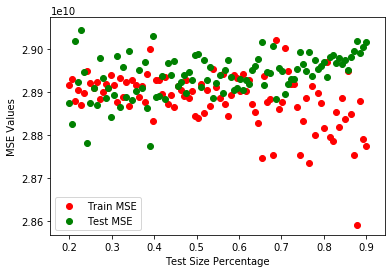

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

#function to run 100 times each (to reduce variance) through a range of train-test split sizes
def test_train(low,high,count):
    linreg = LinearRegression()
    index = np.linspace(low,high,num=count,endpoint=True)
    index = np.around(index, 3)
    train_MSE = []
    test_MSE = []
    for i in index:
        train_errors = []
        test_errors = []
        for x in range(0,100):
            xtrn, xtst, ytrn, ytst = train_test_split(df_model.drop(labels='price', axis=1), df_model.price, test_size=i)
            #print(xtrn.shape, xtst.shape, ytrn.shape, ytst.shape)
            linreg.fit(xtrn, ytrn)
            xtrn_err = linreg.predict(xtrn)
            xtst_err = linreg.predict(xtst)
            mse_train = np.sum((ytrn - xtrn_err)**2)/len(ytrn)
            mse_test = np.sum((ytst - xtst_err)**2)/len(ytst)
            train_errors.append(mse_train)
            test_errors.append(mse_test)
        train_MSE.append(np.mean(train_errors))
        test_MSE.append(np.mean(test_errors))
    return [index, train_MSE, test_MSE]

data = test_train(.2, .9, 100) #100 intervals from 20-90% train-test split each run 100 times

#Plotting our results
plt.scatter(data[0], data[1], color='r', label='Train MSE')
plt.scatter(data[0], data[2], color='g', label='Test MSE')
plt.legend()
plt.xlabel('Test Size Percentage')
plt.ylabel('MSE Values')
plt.show()

#### Calculate the average error at 60% test size

In [44]:
from sklearn.metrics import mean_squared_error
xtrn, xtst, ytrn, ytst = train_test_split(df_model.drop(labels='price', axis=1), df_model.price, test_size=.6)
linreg = LinearRegression()
linreg.fit(df_model.drop(labels='price', axis=1), df_model.price)
xtst_err = linreg.predict(xtst)
test_mse = mean_squared_error(ytst, xtst_err)
np.sqrt(test_mse)

169408.4801542779

### Perform K-Fold Cross Validation

In [46]:
from sklearn.model_selection import cross_val_score
#Run 500 folds to get consistent results
cv_500_results = cross_val_score(linreg, df_model.drop(labels='price', axis=1), df_model.price,
                                cv=500, scoring="neg_mean_squared_error")
print('Root Mean Squared Error : ', np.sqrt(np.mean(cv_500_results)*-1))

Root Mean Squared Error :  170069.86325866467


#### It appears we have a fairly consistent pricing prediction error of $170k. Now let's check for normality with a Q-Q plot and for homoscedasticity by plotting our prediction errors

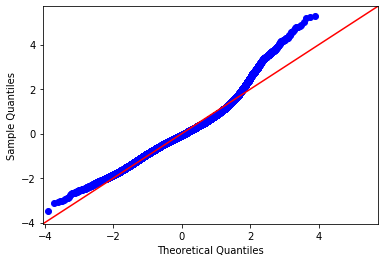

In [48]:
#Check for normality with Q-Q plot
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

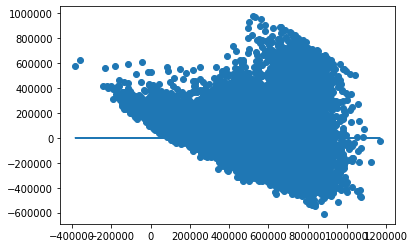

In [49]:
#Check for homoscedasticity
X = df_model.drop(labels='price',axis=1)
plt.scatter(model.predict(X), model.resid)
plt.plot(model.predict(X), [0 for i in range(len(df_model))]);

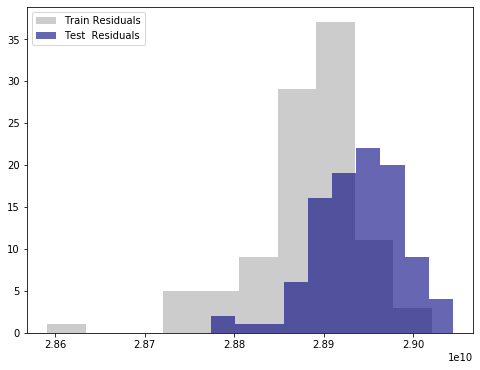

In [52]:
#Plotting train and test residuals to check that their distributions are normal
plt.figure(figsize=(8,6))
plt.hist(data[1], color= 'gray', label='Train Residuals', alpha=0.4)
plt.hist(data[2], color='navy', label='Test  Residuals', alpha=0.6)
plt.legend(loc=2)
plt.show();

#### Our residuals have normality and appear homoscedastic, albeit 'sloping downward'. There seem to be parallel upper and lower bounds sloping downward at 45 degrees.
Out of curiosity, let's see what happens if we just chop off a good chunk of the right tail (high price outliers)!

Properties dropped > $1M: 983 Remaining: 19870


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.916
Model:                            OLS   Adj. R-squared (uncentered):              0.916
Method:                 Least Squares   F-statistic:                          4.319e+04
Date:                Mon, 02 Mar 2020   Prob (F-statistic):                        0.00
Time:                        07:36:53   Log-Likelihood:                     -2.6460e+05
No. Observations:               19870   AIC:                                  5.292e+05
Df Residuals:                   19865   BIC:                                  5.293e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
sqft_living        7.008e+05   8928.154     78.496      0.000    6.83e+05    7.18e+05
lat                6.282e+05   2675.949    234.761      0.000    6.23e+05    6.33e+05
basement           3.581e+04   2388.533     14.994      0.000    3.11e+04    4.05e+04
urban              2.067e+04   2512.981      8.225      0.000    1.57e+04    2.56e+04
floors_(1.5, 3.5]  7.081e+04   2636.055     26.864      0.000    6.56e+04     7.6e+04
==============================================================================
Omnibus:                      105.261   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.218
Skew:                           0.102   Prob(JB):                     5.29e-29
Kurtosis:                       3.340   Cond. No.                         8.89
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

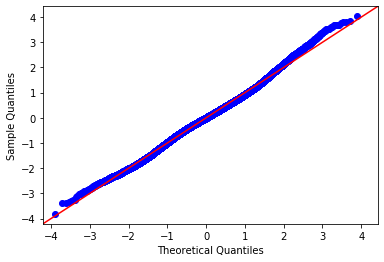

In [53]:
num = len(df_model) #to capture how many properties were dropped under $1M
df_model = df_model[df_model.price<1000000]
print(f'Properties dropped > $1M: {num-len(df_model)}', f'Remaining: {len(df_model)}')

model = sm.OLS(df_model.price, df_model.drop('price', axis=1)).fit()
display(model.summary())
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

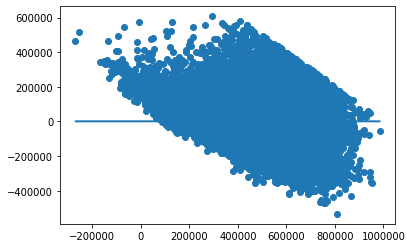

Root Mean Squared Error :  130295.61309117553


In [54]:
X = df_model.drop(labels='price',axis=1)
plt.scatter(model.predict(X), model.resid)
plt.plot(model.predict(X), [0 for i in range(len(df_model))]);
plt.show()

linreg = LinearRegression()
linreg.fit(df_model.drop(labels='price', axis=1), df_model.price)
#Run 500 folds to get consistent results
cv_500_results = cross_val_score(linreg, df_model.drop(labels='price', axis=1), df_model.price,
                                cv=500, scoring="neg_mean_squared_error")
print('Root Mean Squared Error : ', np.sqrt(np.mean(cv_500_results)*-1))

#### Wowza! Our R2 increased to almost 92% and skew/kurtosis reached close to ideal levels, as evidenced by the very nice looking Q-Q plot. The plotted residuals confirmed homoscedasticity as the upper and lower bounds narrowed. The clear negative slope is becoming more apparent.

# Final Conclusions:
### Our original model's Q-Q Plot showed decent normality with a positive skew and a long right tail (high outliers). The mean pricing error was $170k which we can state is almost 90% attributable to our predictive model. The high F-statistics (3-4000) indicates high variance in our model predictions but the zero probability indicates very low variance among our prediction errors.

* When we reduce our dataset to properties under 1M (drop ~1000 properties), our model improves quite dramatically. Normality is closely achieved and our average pricing error drops to 130k. The residuals plot confirms that our model starts to **underprice** heavily for more expensive homes (approaching $1M and beyond).
* Our model appears to have a 'fatal flaw' in that it actually makes negative price predictions for lower priced homes. It is not clear if these residuals would be considered homoscedastic since their range of variance is consistent (and upper/lower bounds appear well defined) but the negative slope indicates that at prices over 1M, our model would be under-predicting worse and worse (although within a consistent error range).

### Future Work: Try different transformations for the categorical features and creatively come up with new ones in order to try and keep as many features as possible while eliminating multicollinearity. Dive deeper into the location (and neighbors) data to see if we can determine if a very specific zipcode/neighborhood is in high demand. Possibly create 4 different regression models (urban, waterfront, rural, land - for the huge lot sizes).

In [ ]:
residuals = np.random.normal(1000,300,100000)

In [3]:
x_vals = np.linspace(0,1,5)
x_vals

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

In [ ]:
x_vals = np.linspace(0,1,len(residuals))

In [ ]:
plt.scatter(x_vals, residuals)

In [ ]:
#Plot train and test residuals to check their distributions are normal
plt.figure(figsize=(8,6))
plt.hist(train_residuals, color= 'gray', label='Train Residuals', alpha=0.4)
plt.hist(test_residuals, color='navy', label='Test Residuals', alpha=0.6)
plt.legend(loc=2)
plt.show();

In [ ]:
#Scatter plots with prediction line of each feature against price
for col in df.columns:
    if col != 'price' and col != 'date': #processing date threw errors, will deal with this column later
        sns.lmplot(x=col, y='price', data=df, line_kws={'color': 'red'})

In [ ]:
#Plot histograms
df.hist(figsize=(18,12), bins=20);

In [ ]:
#scatter matrix
pd.plotting.scatter_matrix(df, figsize=(16,16));

In [ ]:
f = 'price~abcd'
model = ols(formula=f, data=df).fit()
model.summary()

In [ ]:
import statsmodels.formula.api as smf
model = smf.ols(formula='price~date', data=df).fit()
X = pd.DataFrame({'date': [df.date.max(), df.date.min()]})
X_pred = model.predict(X)
plt.scatter(df.date, df.price, s=15, label='Sell Date vs Price')
plt.plot(X, X_pred, c='r', linewidth=2);
plt.legend()
plt.show()

In [ ]:
#function to run 1on1 OLS model looping thru a feature list vs price and print R2 and P values
def get_r2_p(cols):
    output = []
    for col in cols:
        x = df[col]
        X = sm.add_constant(x)
        linreg = sm.OLS(df.price, X).fit()
        output.append([col, linreg.rsquared.round(5), linreg.pvalues[1]])
    print('Feature , R-squared , P-value')
    return output

In [ ]:
get_r2_p(['bedrooms','bathrooms','sqft_living','sqft_lot','floors','view','condition','grade','sqft_above','sqft_basement',
          'yr_built','zipcode','lat','long','sqft_living15','sqft_lot15'])

In [ ]:
#get multicollinearity scores between features
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(df_model.drop(labels='price',axis=1).columns, vif))

In [ ]:
#print price correlation numbers from best to worst
pd.DataFrame(df.corr().price.sort_values(ascending=False)) 